# Extend AI - Take-home project

## Project instructions 
The instruction for this project can be found here: https://github.com/extend-ai/extend-ai-ml-assessment.
As you'll see, the datasets provided is on purpose very small and unpractical as is for a supervised approach. There are many ways to cope with this thus only working with the provided datasets and telling us that we need more data will result in a failure of the test.
This is an open source test so you'll therefore have access to previous candidates solutions. We therefore expect originality in your solution and/or your documentation. If you take inspiration from a previous solution, we would like to know why your choose that particular one and what differentiates yours.

## Project summary

In this project, a convolutionnal autoencoder is selected to identify pictures with\without anomalies. The anomalies are knots or cracks at the wood surface. Data augmentation is performed to cope with a data sample of 7 images. The train dataset is composed of clean datas. The test set is composed of clean datas and pictures with anomalies. 

During the evaluation, all test datas are sent in the model and the losses are calculated as the difference between the reconstructed images and original ones. A loss threshold is determined and the predictions are made on the whole test data. The anomalies are identified as output with higher losses.  The accuracy of our model reaches 78%


Table of contents
- Dataset: the dataset is labelled in folders as clean (0) or as anomaly (1)
- Data Augmentation is performed to cope with the very small dataset. Random crop is not used as we noticed that it could lead to mislabelling if the anomalies are cropped. Images are normalized, resized and either flipped vertically/horizontally, Gaussian blurred or Color Jitter
- Dividing dataset between clean datas and anomalies. The objective is to create a train set only composed of clean datas. The test set is composed of clean datas and anomalies.
- Train\Test split and data loader
- Data Loader visualization: Sanity check
- Autoencoder
- Train the model
- Reconstruction visualization: Sanity check
- Prediction :  'For our model to determine if an input is or is not an anomaly, we will use the loss value from the output and input — if the loss value is high, then we will assume that the model is seeing an element that is outside of the known distribution representation. To achieve this, we will iterate through our test set sequentially and retaining the loss value. It is very important to perform this task sequentially as this will serve us in our analysis of results.' source: https://benjoe.medium.com/anomaly-detection-using-pytorch-autoencoder-and-mnist-31c5c2186329
- Confusion matrix: Confusion matrix where the model is re-evaluted using the previous determined threshold for MSE losses
- Conclusion



## Dataset



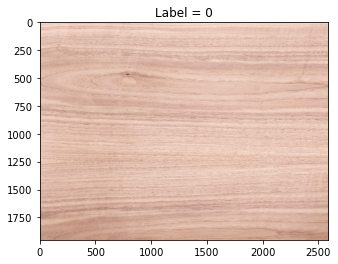

Size of 2592 x 1952 


In [7]:
import matplotlib.pyplot as plt
import torch
#print(torch.__version__)
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

def show_data(sample, infos):
    image, label = sample
    plt.imshow(image)
    plt.title('Label = '+ str(label))
    plt.show()
    if infos == True:
        width, height = image.size
        print(f"Size of {width} x {height} ")

dataset_example = datasets.ImageFolder('./data')
show_data(dataset_example[0], infos=True)

## Data Augmentation

In [8]:
torch.manual_seed(2)

# To resize images
width_target=256
height_target=256

image_transforms = [
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.RandomHorizontalFlip(1.0), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.RandomVerticalFlip(1.0), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.GaussianBlur(kernel_size=(3,3)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.RandomAffine(45), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
]

# Data augmentation
list_datasets = []
for transform in image_transforms:
    dataset = datasets.ImageFolder('./data0', transform=transform)
    #print(dataset.targets)
    list_datasets.append(dataset)
    
augmented_set = torch.utils.data.ConcatDataset(list_datasets)
print(f"Number of images in the augmented dataset is {len(augmented_set)} ")

Number of images in the augmented dataset is 42 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


types: <class 'torch.Tensor'> <class 'int'>
shapes: torch.Size([3, 256, 256]) torch.Size([])


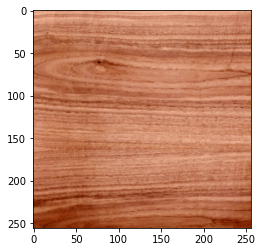

In [9]:
# Visualization

# Sample 
sample = next(iter(augmented_set))
image, label = sample

print('types:', type(image), type(label))
print('shapes:', image.shape, torch.tensor(label).shape)

# Given a Tensor representing the image, use .permute() to put the channels as the last dimension:
plt.imshow(image.permute(1, 2, 0))

# Additional notes: To remove the 1 in the dimension of the image mais ici c'est 3 alors t'es con
#print(image.squeeze().shape)
# Source https://deeplizard.com/learn/video/mUueSPmcOBc

## Dividing dataset between clean and anomalies


In [10]:
clean_set=[]
anomaly_set = [] 

for i in range(len(augmented_set)):
    if augmented_set[i][1] == 1:
        anomaly_set.append(augmented_set[i])
    else:
        clean_set.append(augmented_set[i])

print(' Clean dataset has ' + str(len((clean_set))) + ' elements')
print(' Anomaly dataset has ' + str(len((anomaly_set))) + ' elements')  

 Clean dataset has 24 elements
 Anomaly dataset has 18 elements


In [11]:
# Data augmentation of clean data - adding crop 

#list_datasets = []
#for transform in clean_transforms:
    #dataset = datasets.ImageFolder('./data4', transform=transform)
    #print(dataset.targets)
    #list_datasets.append(dataset)

#dataset.dataset.transform = transforms.Compose([
                #transforms.RandomResizedCrop(28),
                #transforms.ToTensor(),
                #transforms.Normalize((0.1307,), (0.3081,))
            #])

## Train\Test split and data loader


In [12]:
nb_anomalies = 7
nb_clean = 7

# Random_split returns two datasets
train_set , test_set_clean = torch.utils.data.random_split(clean_set, [len(clean_set)-nb_clean, nb_clean], generator=torch.Generator().manual_seed(42))
_ , test_set_anomaly = torch.utils.data.random_split(anomaly_set, [len(anomaly_set)-nb_anomalies, nb_anomalies], generator=torch.Generator().manual_seed(42)) 

# Add anomaly to test_set
test_set = torch.utils.data.ConcatDataset([test_set_anomaly,test_set_clean])

print(' Test dataset has now ' + str(len((test_set))) + ' elements, composed of ' + str(nb_clean) + '  clean  data and ' + str((nb_anomalies)) + ' anomalies')

 Test dataset has now 14 elements, composed of 7  clean  data and 7 anomalies


In [13]:
batch_size=1

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

print(' The train loader has ' + str(len((train_loader))) + ' elements')
print(' The test loader has ' + str(len((test_loader))) + ' elements')

 The train loader has 17 elements
 The test loader has 14 elements


## Data Loader visualization
Plot using directly the data loader with a batch of 10

In [14]:
#  Visualize train data

batch_size=10
train_loader10 = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
batch_iter=iter(train_loader10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train dataloader visualization 


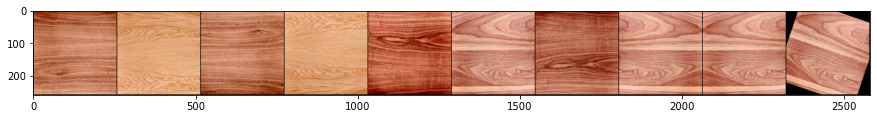

labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [15]:
print('Train dataloader visualization ')

batch = next(batch_iter)
images, labels = batch
# Plot a batch
grid = make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))   
plt.show()
print('labels:', labels)

In [16]:
#  Visualize test data

batch_size=10
test_loader10 = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
batch_iter=iter(test_loader10)

Test dataloader visualization 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


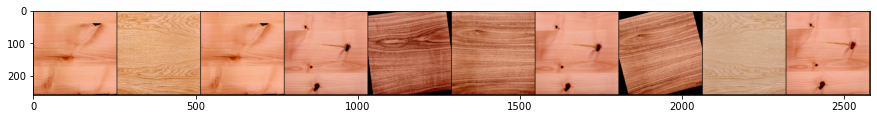

labels: tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 1])


In [17]:
print('Test dataloader visualization ')

batch = next(batch_iter)
images, labels = batch
# Plot a batch
grid = make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))   
plt.show()
print('labels:', labels)

## Autoencoder
source https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=15, kernel_size=5, padding=0, stride=2),  #  256x256x3 to 126x126x15
            nn.ReLU(), 
            nn.MaxPool2d(2, 2) # 126x126x15 to 15x63x63 
            #nn.Conv2d(in_channels=15, out_channels=30, kernel_size=5, padding=0, stride=2), #  126x126x15 to 61x61x30
            #nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=30, out_channels=15, kernel_size=5, stride=2, output_padding=1), # 61x61x30 to 126x126x15
            #nn.ReLU(),
            nn.ConvTranspose2d(in_channels=15, out_channels=3, kernel_size=5, stride=4, output_padding=3),#  15x63x63  to 256x256x3
            nn.ReLU()
        )
    
    def forward(self, x):
        # Encoded
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    

## Train the model

In [19]:
torch.manual_seed(42)
learning_rate = 1e-3

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)
model.train()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss() 

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 15, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(15, 3, kernel_size=(5, 5), stride=(4, 4), output_padding=(3, 3))
    (1): ReLU()
  )
)


In [20]:
epochs = 10
cost_list=[]

for epoch in range(epochs):
    train_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)/len(train_loader)
        
    cost_list.append(train_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        


Epoch: 0 	Training Loss: 0.300219
Epoch: 1 	Training Loss: 0.200328
Epoch: 2 	Training Loss: 0.163999
Epoch: 3 	Training Loss: 0.148198
Epoch: 4 	Training Loss: 0.139343
Epoch: 5 	Training Loss: 0.136961
Epoch: 6 	Training Loss: 0.136895
Epoch: 7 	Training Loss: 0.136608
Epoch: 8 	Training Loss: 0.136350
Epoch: 9 	Training Loss: 0.136223


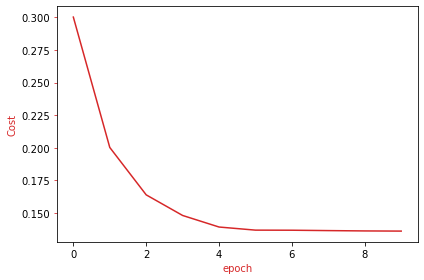

In [21]:
# Visualize convergence

# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
fig.tight_layout()

## Reconstruction visualization

In [22]:
#source:https://github.com/Jimit-Bavishi/extend-ai-ml-assessment/blob/main/extend_ai_assessment.ipynb

def show_results(dataset, idx, infos=True):
    model.eval()
    image, label= dataset[idx]
    input_image = image[None, :, :, :]  # Add extra dimension
    output_image = model(input_image.to(device))
    
    input_image = input_image[0].permute(1, 2, 0)
    output_image = output_image[0].cpu().permute(1, 2, 0).detach()
    loss_image = torch.abs(input_image-output_image)
    
    fig = plt.figure(figsize=(7,2))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('Input - Label:' + str(label))
    ax1.imshow(input_image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Output')
    ax2.imshow(output_image)
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Difference')
    ax3.imshow(loss_image)
    
    if infos==True:
        print(f"Size of input image is {input_image.size()}")
        print(f"Size of output image is {output_image.size()}")
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


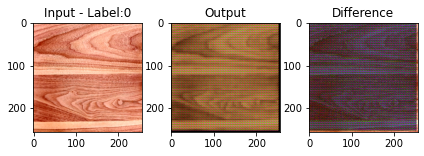

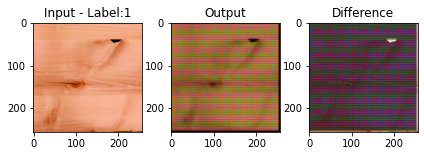

In [23]:

show_results(train_set, 0, infos=False)
show_results(test_set, 0, infos=False)

## Prediction


In [24]:
torch.manual_seed(2)
model.eval()
loss_dist = []
label_list=[]

for data in test_loader:
    images, label = data
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    loss_dist.append(loss.item())
    label_list.append(label.item())

anom_list=[]
clean_list=[]

for i in range(len(label_list)):
    if label_list[i] == 1.0:  # Detected as an anomally
        anom_list.append(loss_dist[i])  
    else:
        clean_list.append(loss_dist[i])  

print(f"Total number of predictions: {len(label_list)}")
print(f"Number of anomalies: {len(anom_list)}")
print(f"Number of clean data: {len(clean_list)}")

Total number of predictions: 14
Number of anomalies: 7
Number of clean data: 7


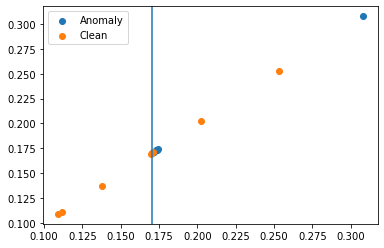

In [25]:
anom_sc = []
clean_sc = []
for i in anom_list:
    anom_sc.append((i,i))
for i in clean_list:
    clean_sc.append((i,i))
plt.scatter(*zip(*anom_sc),label='Anomaly')
plt.scatter(*zip(*clean_sc),label='Clean')
plt.axvline(0.1705, 0.0, 1)
plt.legend()

Define here lower and upper threshold


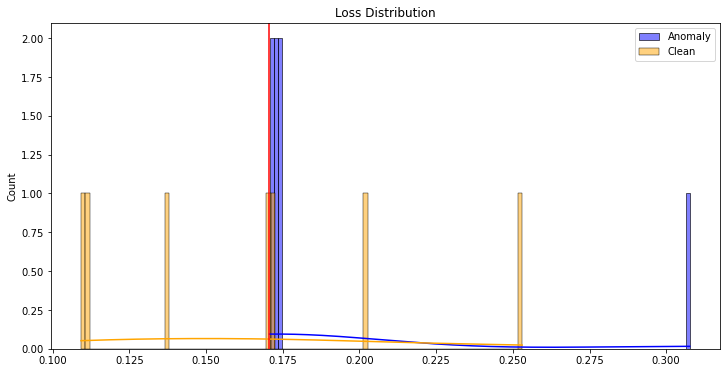

In [27]:
import seaborn as sns

print('Define here lower and upper threshold')
lower_threshold = 0.0
upper_threshold = 0.1705

plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot(anom_list,bins=100,kde=True, label='Anomaly', color='blue')
sns.histplot(clean_list,bins=100,kde=True, label='Clean',color='orange')
plt.axvline(upper_threshold, 0.0, 10, color='r')
#plt.axvline(lower_threshold, 0.0, 10, color='b')
plt.legend()



## Confusion matrix

Confusion matrix whre the model is re-evaluted using the previous determined threshold for MSE losses

In [28]:
model.eval()
loss_dist = []

tp = 0
fp = 0
tn = 0
fn = 0

total_anom = 0

#for bx, data in enumerate(test_):
for data in test_loader:
    images, label = data
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    loss_dist.append(loss.item())
    # Count total number of anomalise
    total_anom += label.item()
    
    if loss>= upper_threshold:  # Detected as an anomally
        #if is anomally (=1) = True Positive  
        #if is clean (=0) = False Positive
        if label == 1.0:
            tp += 1
        else:
            fp += 1 
    else: # Detected as clean
        #if is anomally (=1) = False Negative 
        #if is clean (=0) = True Negative
        if label == 1.0:
            fn += 1
        else:
            tn += 1 
    


[TP] 7	[FP] 3	[MISSED] 0
[TN] 4	[FN] 0
[ACCURACY] 0.7857142857142857


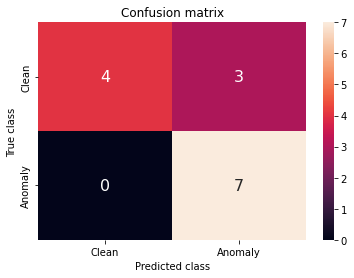

In [29]:
accuracy= (tp+tn)/(tp+tn+fp+fn)
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))
print('[ACCURACY] {}'.format(accuracy))

conf = [[tn,fp],[fn,tp]]


plt.figure()
sns.heatmap(conf, xticklabels=['Clean','Anomaly'], yticklabels=['Clean','Anomaly'], annot=True,annot_kws={"size": 16},fmt='g')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Conclusion

We are able to define an error threshold that enables to differenciate with 78% accuracy a sample image with or without anomalies with a semi-supervised approach.

New eays of improvement:
- The dataset can be increased by adding more different transformations. Other libraries like Albuminations exist to perform data augmentation that provides more variety of image transforms. Also, the width and the height of the pictures could definitely be optimized.
- The model is a simple convolutionnal autoencoder for the sake of simplicity. More work can be put in the network architecture and the fine tuning of hyper parameters. Pre-trained algorthims ResNet are also widely used in the research community and can be directly import in the notebook, the user can custom it in its own way by, per axample,modifying the last fully connected layer. 